# SMOTE Tutorial #
Sometimes, we suffer from having unbalanced datasets which may have some unexpected effects on our ability to classify. The following code just generates the dataset and the test data. Note that this is most devastating when the proportion of our test distribution is different than our training dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
np.random.seed(1)

In [2]:
mu2 = [0, 3]
mu1 = [3, 2]
sigma1 = [[1,0], [0,1]]
sigma2 = [[.2,0],[0,.2]]
n = 5000
m = 50
x1 = np.random.multivariate_normal(mu1, sigma1, size=n).T
x2 = np.random.multivariate_normal(mu2, sigma2, size=m).T
X_train = np.hstack([x1, x2])
y_train = np.hstack([np.ones(n), -1*np.ones(m)])

xt1 = np.random.multivariate_normal(mu1, sigma1, size=1000).T
xt2 = np.random.multivariate_normal(mu2, sigma2, size=1000).T
X_test = np.hstack([xt1, xt2])
y_test = np.hstack([np.ones(1000), -1*np.ones(1000)])

Notice that in our dataset, we have a 1:100 ratio for the minority class to the majority class in the test set, but a 1:1 ratio in our test distribution. Notice how the two classes also somewhat overlap, but the overlap is more due to the overwhelming amount of data points that the majority have.

Text(0.5,1,'Raw Data')

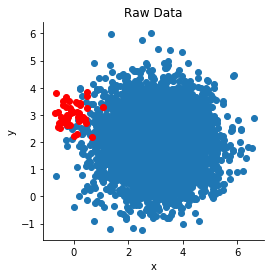

In [3]:
fig, ax = plt.subplots()
ax.scatter(x1[0], x1[1])
ax.scatter(x2[0], x2[1], c="red")
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Raw Data")

Here we will train a logistic regression model and see how well we do with this raw data. 

In [4]:
model = LogisticRegression().fit(X_train.T, y_train)
train_acc = metrics.accuracy_score(y_train, model.predict(X_train.T))

print("Train accuracy:", train_acc)

Train accuracy: 0.995049504950495


Great, we have a 99% accuracy on our classifier. However, this is where the paradox of accuracy comes into play. Let us look at the accuracy for the test set and the AUROC scores for each of the test sets.

In [5]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, model.predict(X_train.T))
train_auc = metrics.auc(fpr, tpr)
fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test.T))
test_auc = metrics.auc(fpr, tpr)
test_acc = metrics.accuracy_score(y_test, model.predict(X_test.T))

print("Train AUROC: ", train_auc)
print("Test accuracy:", test_acc)
print("Test AUROC: ", test_auc)

Train AUROC:  0.8589
Test accuracy: 0.824
Test AUROC:  0.824


It looks like our test accuracy isn't great consider how good the training accuracy is. Let us plot the classifications and see how the classification boundary seems to be.

In [6]:
def plot(X, y):
    X = X.T
    class1 = X[np.where(y == 1)].T
    class2 = X[np.where(y == -1)].T
    fig, ax = plt.subplots()
    ax.scatter(class1[0], class1[1])
    ax.scatter(class2[0], class2[1], c="red")
    ax.set_aspect("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title("Results")

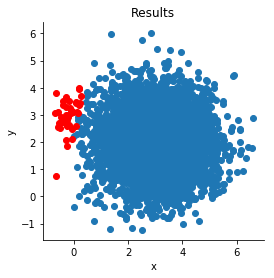

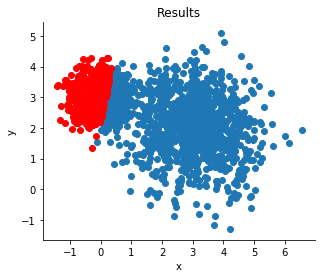

In [7]:
plot(X_train, model.predict(X_train.T))
plot(X_test, model.predict(X_test.T))

Now we can see where our problems lie. Because there are so little samples of the minority class, the algorithm is favoring the majority class in training. Thus, when we go to the test set, we can very clearly see that while the two blobs are very clearly seperable, the algorithm takes a chunk out of the minority class's data points. 

This is a problem that can be solved if we had access to more data of the minority class at training time. Thus, we shall implement SMOTE like in the notes to try and mitigate the following problem. Implement the following SMOTE method. The parameter $X$ is the dataset that we are basing the algorithm on, the parameter $k$ is the number of neighbors for the nearest neighbor classifier, the parameter $a$ is used to calculate the convex hull of the two samples and $num\_samples$ should be the number of synthetic samples to generate. Note that sklearn.neighbors.NearestNeighbors has been imported and should allow for efficient nearest neighbors.

In [8]:
from sklearn.neighbors import NearestNeighbors

def SMOTE(X, k, a, num_samples):
    ##Code starts here ##
    X = X.T
    knn = NearestNeighbors(n_neighbors=k+1)
    knn.fit(X)
    synth = []
    
    indices = np.random.choice(X.shape[0], size=num_samples)
    query = X[indices]
    neighbors = knn.kneighbors(query, return_distance=False)
    random_choices = np.random.choice(k, size=num_samples)+1
    neigh = [neighbors[j][random_choices[j]] for j in range(len(random_choices))]
    samp = X[neigh]
    return a*query + (1-a)*samp
    

Now that we have generated this algorithm, let us try and visualize the samples that SMOTE generated. If you did it correctly, you should see a black mass of points where the minority class is centered around.

In [9]:
xs = SMOTE(x2, 5, 0.5, 3000)
xs = xs.T

Text(0.5,1,'Raw Data')

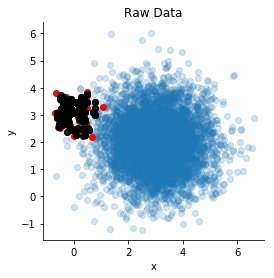

In [10]:
fig, ax = plt.subplots()
ax.scatter(x1[0], x1[1], alpha=0.2)
ax.scatter(x2[0], x2[1], c="red")
ax.scatter(xs[0], xs[1], c="black", alpha=0.2)
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Raw Data")

Let us try and see how this newly augmented training set does at training time.

In [11]:
X_train_aug = np.hstack([X_train, xs])
y_train_aug = np.hstack([y_train, -1 * np.ones(3000)])

model = LogisticRegression().fit(X_train_aug.T, y_train_aug)
fpr, tpr, thresholds = metrics.roc_curve(y_train, model.predict(X_train.T))
train_acc = metrics.accuracy_score(y_train, model.predict(X_train.T))
train_auc = metrics.auc(fpr, tpr)
fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test.T))
test_auc = metrics.auc(fpr, tpr)
test_acc = metrics.accuracy_score(y_test, model.predict(X_test.T))

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)
print("Train AUROC: ", train_auc)
print("Test AUROC: ", test_auc)

Train accuracy: 0.9899009900990099
Test accuracy: 0.9815
Train AUROC:  0.9751
Test AUROC:  0.9814999999999999


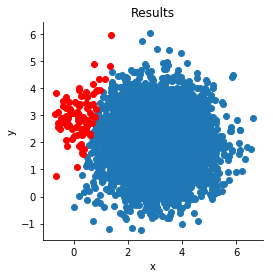

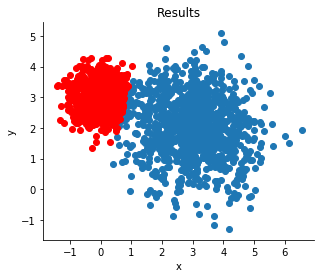

In [12]:
plot(X_train, model.predict(X_train.T))
plot(X_test, model.predict(X_test.T))

You should see that after we augment the training set, we can see that our model does much better on the test set in exchange for a little bit of loss on the original training set. Thus, we can see how adding synthetic samples to augment a training set can help us do better at test time. 

## Question 1 ##
Can you think of any case where SMOTE would not be a good algorithm to use on the data points? 

## Student Answer ##
Very clearly, this implementation of SMOTE relies on the euclidian distance metric as a good metric for nearest neighbors. This may not be very good for a dataset that cannot be reduced down to just clustering. In addition, just using the convex hull of the two datasets is not applicable for different datapoints, especially if you didn't preprocess them before hand. If you have two pictures of a flower and just overlay them over each other, this might not be the best way to generate a syntehtic image of a flower. In any dataset where the data isn't centralized around a centroid, using the convex hull between two points and add more noise than necessary to the training algorithm. 

## Question 2 ##

Can you think of any case where we wouldn't want to rebalance the classes?

## Student Answer ##

Consider that in the model, when we rebalanced the classes, we definitely got misclassification on the majority class, which can be troublesome depending on the cost of a false positive. Consider a case where the minority class is an indicator for replacing a part. If the part is really expensive, we really don't want to have to keep replacing parts that can potentially keep being used. In this case, the conservative estimate of the original dataset might be useful. 